# LSTM CharRNN - with different encoding strategies

### Imports and data processing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import numpy as np
import string
import random
import matplotlib.pyplot as plt
import timeit
import pickle

In [2]:
# Load the dataset
with open('shakespeare.txt', 'r') as f:
    text = f.read()

# Create character to index and index to character mappings
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}
printable_chars = tuple(set(string.printable))
printable_int2char = dict(enumerate(printable_chars))
printable_char2int = {ch:ii for ii,ch in printable_int2char.items()}

# Encode by character
encoded = np.array([char2int[ch] for ch in text])


## Encode the character pairs within the text
double_encoded = []
double_char2int = {}

# Grab all of the character pairs
for i in range(len(text) - 1):
    pair = text[i:i+2]
    if pair not in double_char2int:
        # Assign the next number to any new pairs
        double_char2int[pair] = len(double_char2int)
    # Encode the character pair with its numerical representation
    double_encoded.append(double_char2int[pair])
    #print(pair, double_char2int[pair])

double_int2char = {i: ch for ch, i in double_char2int.items()}
double_encoded = np.array(double_encoded)
pairs = tuple(set(double_char2int.keys()))


total_chars = len(chars)
total_pairs = len(pairs)
total_labels = 0


# We can see that there are 65 different characters within the tinyshakespeare dataset,
# far less than the total amount of printable characters,
print(total_chars, len(printable_chars))
print(char2int)
# Similarly, we can see that there are far less unique pairs of characters within the text than are possible.
# We will ignore pairs not included (like zz) to save on processing (and these pairs likely would be ignored anyways)
# Though this also means that we'll have to be careful if we ever ask this network to produce text from a string 
# that isn't included in this encoding.  We'll handle that in a function later.
print(total_pairs, total_chars**2)
print(double_char2int)

65 100
{'L': 0, '!': 1, ';': 2, '?': 3, 'W': 4, ':': 5, 'R': 6, 'v': 7, 'p': 8, 'i': 9, 'a': 10, 't': 11, 'f': 12, 'M': 13, 'E': 14, 'g': 15, '-': 16, 'y': 17, 'G': 18, '&': 19, 'o': 20, 's': 21, 'd': 22, 'u': 23, "'": 24, 'H': 25, 'U': 26, 'r': 27, 'x': 28, 'I': 29, 'D': 30, 'q': 31, 'b': 32, 'Q': 33, 'c': 34, '.': 35, 'l': 36, 'm': 37, 'z': 38, 'O': 39, 'j': 40, ' ': 41, 'V': 42, 'F': 43, 'B': 44, 'Y': 45, 'T': 46, ',': 47, 'n': 48, '\n': 49, '3': 50, 'C': 51, 'w': 52, 'e': 53, 'X': 54, 'P': 55, 'S': 56, '$': 57, 'A': 58, 'K': 59, 'Z': 60, 'N': 61, 'k': 62, 'h': 63, 'J': 64}
1403 4225
{'Fi': 0, 'ir': 1, 'rs': 2, 'st': 3, 't ': 4, ' C': 5, 'Ci': 6, 'it': 7, 'ti': 8, 'iz': 9, 'ze': 10, 'en': 11, 'n:': 12, ':\n': 13, '\nB': 14, 'Be': 15, 'ef': 16, 'fo': 17, 'or': 18, 're': 19, 'e ': 20, ' w': 21, 'we': 22, ' p': 23, 'pr': 24, 'ro': 25, 'oc': 26, 'ce': 27, 'ee': 28, 'ed': 29, 'd ': 30, ' a': 31, 'an': 32, 'ny': 33, 'y ': 34, ' f': 35, 'fu': 36, 'ur': 37, 'rt': 38, 'th': 39, 'he': 40, 'er

## Network definitions

In [3]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_on_gpu = torch.cuda.is_available()
print(device)

cuda:0


In [4]:
class CharRNN_normal(torch.nn.Module):
    def __init__(self, tokens, n_hidden=500, n_layers=2, batch_size=64, drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.batch_size = batch_size
        self.lr = lr

        self.labels = tokens #string.printable
        self.printable_chars = printable_chars
        self.int2char = dict(enumerate(self.labels))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()} #dict(enumerate(self.printable_chars)).items()
        self.output_size = len(self.labels) #len(self.printable_chars)
        
        self.lstm = torch.nn.LSTM(self.output_size, n_hidden, n_layers,
                                  dropout=drop_prob, batch_first=True)

        self.dropout = torch.nn.Dropout(drop_prob)

        self.linear = torch.nn.Linear(n_hidden, self.output_size)

    def forward(self, x, hidden):
        # self.lstm's x wants (batch_size, seq_length, total_labels)
        r_output, hidden = self.lstm(x, hidden)
        out = self.dropout(r_output)
        out = out.contiguous().view(-1, self.n_hidden)
        out = self.linear(out)
        return out, hidden

    def init_hidden(self, batch_size): #=self.batch_size):
        weight = next(self.parameters()).data
        if train_on_gpu:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        return hidden

In [5]:
class CharRNN_doubleEncode(torch.nn.Module):
    def __init__(self, tokens, n_hidden=300, n_layers=2, batch_size=64, drop_prob=0.2, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.batch_size = batch_size
        self.lr = lr

        self.labels = tokens
        self.double_int2char = double_int2char
        self.double_char2int = double_char2int
        self.output_size = len(self.labels)
        
        self.lstm = torch.nn.LSTM(self.output_size, n_hidden, n_layers,
                                  dropout=drop_prob, batch_first=True)

        self.dropout = torch.nn.Dropout(drop_prob)

        self.linear = torch.nn.Linear(n_hidden, self.output_size)

    def forward(self, x, hidden):
        # self.lstm's x wants (batch_size, seq_length, total_pairs)
        r_output, hidden = self.lstm(x, hidden)
        out = self.dropout(r_output)
        out = out.contiguous().view(-1, self.n_hidden)
        out = self.linear(out)
        return out, hidden

    def init_hidden(self, batch_size): #=self.batch_size):
        weight = next(self.parameters()).data
        if train_on_gpu:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        return hidden

## Encoding functions

In [6]:
# Function to one-hot encode the characters
def one_hot_encode(arr, n_labels=total_labels):
    # arr is shape seq_length, batch_size
    arr = arr.transpose(1,0)
    oh = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    oh[np.arange(oh.shape[0]), arr.flatten()] = 1
    oh = oh.reshape((*arr.shape, n_labels))
    return oh.transpose(1,0,2)

### Actually, didn't end up using these :( ###
# # Function to one-hot encode groups of 2 characters, in attempt to increase contextual range
# def one_hot_encode_double(arr, n_labels=total_labels):
#     # arr is shape seq_length, batch_size
#     arr = arr.transpose(1,0)
#     if (arr.shape[1]%2 == 1): arr = np.insert(arr, 0, 5, axis=1) # " " is 5, to make the new seq_length even
#     new = np.zeros((arr.shape[0], int(arr.shape[1]/2)), dtype=int)
#     oh = np.zeros((*(new.shape), n_labels**2), dtype=np.float32) # *(new.shape) here because .shape returns a tuple
#     # below only works because arr has been pre-processed to be from min-index to max-index
#     for i in range(0, arr.shape[1], 2):
#         new[:,int(i/2)] = n_labels*arr[:,i] + arr[:,i+1]
#     oh[np.arange(oh.shape[0])[:,None], np.arange(oh.shape[1]), new] = 1
#     # oh = oh.reshape((*new.shape, n_labels**2))
#     # Ex. oh of n**2 = 9, (batch,seq) [1,2],[3,4],[5,0] would be
#     # [[0,1,0,0,0,0,0,0,0], [0,0,1,0,0,0,0,0,0]
#     #  [0,0,0,1,0,0,0,0,0], [0,0,0,0,1,0,0,0,0]
#     #  [0,0,0,0,0,1,0,0,0], [1,0,0,0,0,0,0,0,0]]
    
#     # returns oh of shape seq_length, batch_size, n_labels**2
#     return oh.transpose(1,0,2)

# def target_to_double(target_arr, n_labels=total_labels):
#     target_arr = target_arr.transpose(1,0)
#     if (target_arr.shape[1]%2 == 1): target_arr = np.insert(target_arr, 0, 76, axis=1) # " " is 5, to make the new seq_length even
#     converted = np.zeros((target_arr.shape[0], int(target_arr.shape[1]/2)), dtype=int)
#     for i in range(0, target_arr.shape[1], 2):
#         converted[:,int(i/2)] = n_labels*target_arr[:,i] + target_arr[:,i+1]
#     return converted.transpose(1,0)

# def double_to_char(doubled, n_labels=total_labels):
#     doubled = doubled.transpose(1,0)
#     reverted = np.zeros((doubled.shape[0], int(doubled.shape[1]*2)), dtype=int)
#     for i in range(0, doubled.shape[1]):
#         reverted[:, i+1] = doubled[:, i] % n_labels
#         reverted[:, i] = (doubled[:, i] - reverted[:, i+1]) / n_labels
#     return reverted.transpose(1,0)## Encoding functions

## Batching functions

In [7]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq_and_target(arr, seq_length):
    start_index = random.randint(0, len(arr) - seq_length - 1)
    end_index   = start_index + seq_length + 1 - 1
    return arr[start_index:end_index], arr[start_index+1:end_index+1]

# Get a random paired sequence of the Shakespeare dataset.
# Iterates 2 indexes at a time
def pair_get_random_seq_and_target(arr, seq_length):
    increment = 2
    start_index = random.randint(0, len(arr) - 2*seq_length - increment)
    end_index   = start_index + 2*seq_length + increment - increment
    return arr[start_index:end_index:2], arr[start_index+increment:end_index+increment:2]
### WORTH PAYING ATTENTION TO INCREMENT OF TARGET - +1 vs +2 could make a huge difference here


def get_batches(arr, batch_size, seq_length, batches_per_iter, pair_mode = False, n_labels=total_labels):
    '''Arguments
       ---------
       arr: Total char array to make batches from, 1-D
       batch_size: the number of sequences per batch
       seq_length: number of encoded chars per sequence
       batches_per_iter: how many sets for batches per iter/epoch
       pair_mode: whether to collect from double_encode or not
       n_labels: the total number of possible labels
    '''

    # We want batch to be seq_length,batch_size (128,64)

    batch_size_total = batch_size * seq_length
    batch = np.zeros((seq_length, batch_size), dtype=int)
    target = np.zeros((seq_length, batch_size), dtype=int)
    
    for b in range(0, batches_per_iter):
        # iterate through the array, one random sequence at a time
        for n in range(0, batch_size):
            if pair_mode:
                batch[:,n], target[:,n] = pair_get_random_seq_and_target(arr, seq_length)
            else:
                batch[:,n], target[:,n] = get_random_seq_and_target(arr, seq_length)
        yield torch.from_numpy(one_hot_encode(batch, n_labels=n_labels).transpose(1,0,2)), torch.from_numpy(target.transpose(1,0))

## Training

In [8]:
def train_step(net, opt, loss_func, batch_size, input, target):
    # Initialize hidden state and gradients.
    hidden = net.init_hidden(batch_size)
    opt.zero_grad()
    
    # Forward pass.
    output, hidden = net(input, hidden)
    
    # Compute loss. Flatten output and target tensors and compute cross-entropy.
    loss = loss_func(output.reshape(-1, net.output_size), target.reshape(-1))

    # Backward pass and optimization.
    loss.backward()
    opt.step()

    return loss.item()

def train(net, data, pair_mode = False, epochs=10, batch_size=64, seq_length=128, lr=0.001, clip=5, val_frac=0.1, print_every=100):
    ''' Training a network

        Arguments
        ---------

        net: CharRNN_normal network
        data: text data to train the network
        pair_mode: whether to refer to double_encode or not
        epochs: Number of epochs.iters to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss

    '''
    all_losses = []
    loss_sum   = 0
    
    net.train()
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    loss_func = torch.nn.CrossEntropyLoss()

    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]

    if(train_on_gpu):
        net.cuda()

    counter = 0
    'THIS AFFECTS INPUT SIZE'
    n_labels = len(net.labels)
    batches_per_iter=1000
    
    
    start_train = timeit.default_timer()
    
    for e in range(epochs):
        for input, target in get_batches(data, batch_size, seq_length, batches_per_iter, pair_mode=pair_mode, n_labels=n_labels):
            input, target = input.to(device), target.to(device) # Move to GPU memory.
            #print("input+target shape:", input.shape, target.shape)
            #input+target shape: torch.Size([128, 64, 65]) torch.Size([128, 64])
            
            loss      = train_step(net, opt, loss_func, batch_size, input, target)   # Calculate the loss.
            loss_sum += loss                                  # Accumulate the loss.
            
            counter += 1
            # Print the log.
            if counter % print_every == print_every - 1:
                print('iter:{}/{} loss:{}'.format(counter+1, batches_per_iter, loss_sum / print_every))
                #print('generated sequence: {}\n'.format(eval_step(net)))

                # Track the loss.
                all_losses.append(loss_sum / print_every)
                loss_sum = 0
        
        val_h = net.init_hidden(batch_size)
        val_losses = []
        net.eval()
        for input, target in get_batches(val_data, batch_size, seq_length, batches_per_iter=5, pair_mode=pair_mode, n_labels=n_labels):
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            val_h = tuple([each.data for each in val_h])

            if(train_on_gpu):
                input, target = input.cuda(), target.cuda()

            output, val_h = net(input, val_h)
            val_loss = loss_func(output.reshape(-1, net.output_size), target.reshape(-1))
            val_losses.append(val_loss.item())

        net.train() # reset to train mode after iterationg through validation data
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Step: {}...".format(counter),
              "Loss: {:.4f}...".format(loss),
              "Val Loss: {:.4f}".format(np.mean(val_losses)))

    
    end_train = timeit.default_timer()
    print ("Training time elapsed:", end_train - start_train, "s")
    
    return loss_sum, all_losses

#### Initialize and train

In [9]:
### Normal CharRNN ###

n_hidden = 300
n_layers = 2
dropout = 0.5
batch_size = 64
seq_length = 128
n_epochs = 20
learning_rate = 0.001

total_labels = total_chars
double = False

net = CharRNN_normal(chars, n_hidden, n_layers)
print(net)
print(sum(p.numel() for p in net.parameters()))
# # train the model
# loss_sum, all_losses = train(net, encoded, epochs=n_epochs, batch_size=batch_size, 
#                              seq_length=seq_length, lr=learning_rate, print_every=500)


### Double Encoded CharRNN ###

n_hidden = 170
n_layers = 2
dropout = 0.4
batch_size = 64
seq_length = 128
n_epochs = 15
learning_rate = 0.001

total_labels = total_pairs
double = True

netDouble = CharRNN_doubleEncode(pairs, n_hidden, n_layers, drop_prob=dropout)
print(netDouble)
print(sum(p.numel() for p in netDouble.parameters()))
# train the model
loss_sum, all_losses = train(netDouble, double_encoded, pair_mode = True, epochs=n_epochs, batch_size=batch_size, 
                             seq_length=seq_length, lr=learning_rate, print_every=100)


# torch.save(net.state_dict(), 'SequenceRNN_params_ -layers h- .pth')
# with open('SequenceRNN_lossList_ -layers h- _loss- .pkl', 'wb') as file:
#     pickle.dump(all_losses, file)
# torch.save(netDouble.state_dict(), 'DoubleRNN_params_standard.pth')
# with open('DoubleRNN_lossList_standard.pkl', 'wb') as file:
#     pickle.dump(all_losses, file)

CharRNN_normal(
  (lstm): LSTM(65, 300, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=300, out_features=65, bias=True)
)
1182365
CharRNN_doubleEncode(
  (lstm): LSTM(1403, 170, num_layers=2, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=170, out_features=1403, bias=True)
)
1543473
iter:100/1000 loss:5.947876739501953
iter:200/1000 loss:5.78947594165802
iter:300/1000 loss:5.6466197538375855
iter:400/1000 loss:5.423914928436279
iter:500/1000 loss:5.18526487827301
iter:600/1000 loss:4.890898160934448
iter:700/1000 loss:4.64752426147461
iter:800/1000 loss:4.489025683403015
iter:900/1000 loss:4.373026790618897
iter:1000/1000 loss:4.275673508644104
Epoch: 1/15... Step: 1000... Loss: 4.1895... Val Loss: 4.2492
iter:1100/1000 loss:4.19410397529602
iter:1200/1000 loss:4.121131644248963
iter:1300/1000 loss:4.067677206993103
iter:1400/1000 loss:4.010718848705292
iter

#### Training loss curve

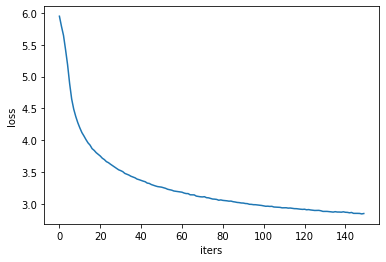

In [10]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot([loss for loss in all_losses])
plt.show()

In [11]:
#print(sum(p.numel() for p in net.parameters()))
#print(sum(p.numel() for p in netDouble.parameters()))

In [12]:
### Single encode ###
## 3 layers, 300 hidden, dropout 0.5, 0.001 lr, 20 epochs
#  909s train time, 1.271 train loss, 1.609 val loss
## blah
#  blah

### Double encode ###
## 2 layers, 300 hidden, dropout 0.2, 0.001 lr, 5 epochs
# 275s train time, 1.433 train lost, 1.694 val loss
# words are not complete though
## 3 layers, 400 hidden, dropout 0.3, 0,001 lr, 25 epochs, seq len 200
# 4281 train time, 1.7558 train loss, 4.803 val loss
# what is interesting here is that loss is way high, but the words are a lot more robust, and you can
# even sense some emotion coming from responses... like romeo sounds sad

## Text generation

In [13]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100, eval_batch_size=3):
    # Enter eval mode
    net.eval()
    
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden(eval_batch_size)
    encoded_seq = np.array([char2int[ch] for ch in init_seq])
    init_input    = torch.from_numpy(one_hot_encode(np.array(([encoded_seq]*eval_batch_size))
                                    .reshape(eval_batch_size, len(init_seq)).transpose(1,0)).transpose(1,0,2)).to(device)
    predicted_seq = np.array(([ch for ch in init_seq]*eval_batch_size)).reshape(eval_batch_size, len(init_seq))
    # predicted_seq.shape = (batch, seq, 0)
    
    # Use initial string to "build up" hidden state.
    #print(init_input[:,0,:].unsqueeze(1).shape)
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[:,t,:].unsqueeze(1), hidden) # input shape (batch_size, seq_length, n_chars)
        
    # Set current input as the last character of the initial string.
    input = init_input[:,-1,:].unsqueeze(1)
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = tuple(torch.multinomial(output[:, :].exp(), 1)[:].flatten().tolist())
        #predicted_index = torch.multinomial(output[:, :].exp(), 1)[:].numpy()
        
        # Add predicted character to the sequence and use it as next input.
        predicted_chars  = [int2char[i] for i in predicted_index]
        predicted_seq = np.concatenate((predicted_seq, np.expand_dims(predicted_chars, axis=1)), axis=1)

        
        # Use the predicted character to generate the input of next round.
        input = torch.from_numpy(one_hot_encode(np.array(predicted_index)
                                .reshape(1, eval_batch_size)).transpose(1,0,2)).to(device)

    return [''.join(row) for row in predicted_seq]



# Pairwise evaluation step function.
# with iter=1, it produces staggered language... like double letters
def double_eval_step(net, init_seq='Wh', predicted_len=100, eval_batch_size=3):
    # Enter eval mode
    net.eval()
    
    init_seq = [init_seq[i:i+2] for i in range(0, len(init_seq), 2)]
    
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden(eval_batch_size)
    encoded_seq = np.array([double_char2int[ch] for ch in init_seq])
    init_input    = torch.from_numpy(one_hot_encode(np.array(([encoded_seq]*eval_batch_size))
                                    .reshape(eval_batch_size, len(init_seq)).transpose(1,0), n_labels=len(net.labels)).transpose(1,0,2)).to(device)
    predicted_seq = np.array(([ch for ch in init_seq]*eval_batch_size)).reshape(eval_batch_size, len(init_seq))
    # predicted_seq.shape = (batch, seq, 0)
    
    # Use initial string to "build up" hidden state.
    #print(init_input[:,0,:].unsqueeze(1).shape)
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[:,t,:].unsqueeze(1), hidden) # input shape (batch_size, seq_length, n_chars)
        
    # Set current input as the last character of the initial string.
    input = init_input[:,-1,:].unsqueeze(1)
    
    counter=0
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        counter += 1
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = tuple(torch.multinomial(output[:, :].exp(), 1)[:].flatten().tolist())
        #predicted_index = torch.multinomial(output[:, :].exp(), 1)[:].numpy()
        
        # Add predicted character to the sequence and use it as next input.
        predicted_chars  = [double_int2char[i] for i in predicted_index]
        'v TO AVOID DOUBLING PROBLEM, LIKELY FROM ITERATOR IN THE RANDOM SEQUENCE FUNCTION'
        #if counter%2 == 0:
        predicted_seq = np.concatenate((predicted_seq, np.expand_dims(predicted_chars, axis=1)), axis=1)

        
        # Use the predicted character to generate the input of next round.
        input = torch.from_numpy(one_hot_encode(np.array(predicted_index)
                                .reshape(1, eval_batch_size), n_labels=len(net.labels)).transpose(1,0,2)).to(device)

    return [''.join(row) for row in predicted_seq]

In [14]:
batches = 5
#generated_seqs = eval_step(net, pair_mode = double, init_seq='ROMEO', predicted_len=200, eval_batch_size=batches)
generated_seqs = double_eval_step(netDouble, init_seq='Wh', predicted_len=300, eval_batch_size=batches)


for i in range(batches):
    print(generated_seqs[i])
    print("\n-------------------------------------\n")

Whese shree, lad'd I am sons: kill, hearing
Hase make him with wash I'll came unwe accanting
of that best; and where thou do done, who noblest.
When this will all.

ROMEO:
O, thank you, remy left even as hold
joy faselood, but fothe Edward's thy flopers, speak, end.

KING EDWARD IV:
Peace!

SAMPSON:
But say you proported may she is hear such see on.

DUKE VINCENTIO:
O here not the good senfore back with thy dromely,
A Envish they thou cilderish but the see;
For, ho! doth be his meet. By the bolinasion,
Well him for hear fow any cous of show.

KING EDWARD IV:
Now larh, this reeducill'd and all on

-------------------------------------

Whom he in thy liberty,
Fompone their hile-hand might as I poul must stroat
The wretched to if him, in a strove had knights,
I thinks and wolly forth, some hand trouding feed
the souls for yours: with stumble; that I proceed to your
provipel, for this finger; where they strange mooth much lords.
Put our soldiers as so.

CORIOLANUS:
But sost, the prince? H

In [15]:
# def predict(net, char, h=None, top_k=None):
#         ''' Given a character, predict the next character.
#             Returns the predicted character and the hidden state.
#         '''

#         # tensor inputs
#         x = np.array([[net.char2int[char]]])
#         x = one_hot_encode(x, len(net.chars))
#         inputs = torch.from_numpy(x)

#         if(train_on_gpu):
#             inputs = inputs.cuda()

#         # detach hidden state from history
#         h = tuple([each.data for each in h])
#         # get the output of the model
#         out, h = net(inputs, h)

#         # get the character probabilities
#         p = F.softmax(out, dim=1).data
#         if(train_on_gpu):
#             p = p.cpu() # move to cpu

#         # get top characters
#         if top_k is None:
#             top_ch = np.arange(len(net.chars))
#         else:
#             p, top_ch = p.topk(top_k)
#             top_ch = top_ch.numpy().squeeze()

#         # select the likely next character with some element of randomness
#         p = p.numpy().squeeze()
#         char = np.random.choice(top_ch, p=p/p.sum())

#         # return the encoded value of the predicted char and the hidden state
#         return net.int2char[char], h

# def sample(net, size, prime='The', top_k=None):

#     if(train_on_gpu):
#         net.cuda()
#     else:
#         net.cpu()

#     net.eval() # eval mode

#     # First off, run through the prime characters
#     chars = [ch for ch in prime]
#     h = net.init_hidden(1)
#     for ch in prime:
#         char, h = predict(net, ch, h, top_k=top_k)

#     chars.append(char)

#     # Now pass in the previous character and get a new one
#     for ii in range(size):
#         char, h = predict(net, chars[-1], h, top_k=top_k)
#         chars.append(char)

#     return ''.join(chars)

# print(sample(net, 1000, prime='JULIET', top_k=5))

In [16]:
# from 3x400, seq len 200

'''
ROMEO:
Must with your victoties are have turn'd.

First Servingman:
Why, war, now follows a well-maid, well not would a
gottour husband,
That I can wish ear to behold his worship,
Which with the rest, when you wrong and so her,
Twenty your presentate: and he will know
So minapet is to fall, of this yould by
The sting o' the royal unten to hour:
But I am so please, and see my lord
But at it here was I w

-------------------------------------


ROMEO:
The lastest in all soul of oppot; but what you may:
Where is your brother?

GREEN:
Well me, before I pas there, and why what is la?
Should you have been foe in out of thinkes,
I must not prose debthe and thing to die:
I had to leat way moved him to the same,
And so he end in the distreation of yourself.
If I am of soversigatio, they do impershind
A dead deliner by Bolingbroke.
With you but love 

-------------------------------------


ROMEO:
But say that Bay, so will I.

PERDITA:
O
Light, there be so grow by were I for a wholeson:
Speak against this holy son?

Second Murderer:
'Zounds, what mitadvance there's men i' the crown?

Clown:
'Twere eye to deep the membles: my fair laid, he's
poacting thy set thee, which we do use here? what, ho!
What worke, letsown, you not?

COMINIUS:
Cuter!

MENENIUS:
For, marry, so at yother better have

-------------------------------------


ROMEO:
O, for this grievous father,
One breath the prince my sorties art a passage
Even in my holour, be or and fool about
In mine own times, stroke an ant's leaves of the part
As with a manners do look now, to be dead.
Either thou art, hence. As she's none enemy,
Soften her beseasure of the thatn of him
When I will know the at in blessing:
need we come mean there all unburning thee
And do myself and o

-------------------------------------


ROMEO:
The proud mischance with nothing's disposition;
And not with any miness noble undertoos:
He hath sainting difference them to speak unto their
friends, that seek for yourselp; but, his office, will
you an ever's roodly gog, as welcome, but we arrive,
what couldste to their master, whereing that is cast
shear, son; my lord and honour's.

KING RICHARD III:
Why, so much unfancy with me rather there!

-------------------------------------
'''






'''

me we shall not like.

ESCALUS:
And we do proud? Where is he cames.

LUCIO:
Become by Saint in his boy, being modest:
My noble lords have last to lose his own,
The love be mew'd in such a dudd of mocker.

QUEEN MARGARET:
Nurserves upon some paly, look at his sil.

EDWARD:
Claimio is will do this white fall of death.

KING RICHARD III:
My lord, he charge thee, tender may in most,
Whom I find poor thrive gives to him my love.

WARWICK:
O maline that fellow, if a begin for me!

QUEEN MARGARET:
That will not be mine houglips and tell it:
Ra' Henry, let us well devilling made
A great sise, by the oop

-------------------------------------

me possess you of things apprehends.

WARWICK:
How now! what news?

Messenger:
My gracious lord,
That there do his thing that only live.

HENRY BOLINGBROKE:
You bestrick, and reason'd mensor--
Was much with the impostable face!

BENVOLIO:
Ay, but this buried.

PERDITA:
You were command.

CLIFFORD:
Methor; and the rest is raskind; and I
shall away thy sirk, sweet belly.

ROMEO:
I know thy unk to him, we will not
I will be vow'd, and 'tis time, thou wilt thou not
Escrees though, who I know
To light our lobss, and he dishonour'd blood.
Is hewn, Amal, More out or losuliess that he be
That a wound ou

-------------------------------------

mel'd many condemned shame:
Reproach false which each must be king, with raidings
Shall never bonge for the swifter of this worse.

BALTHASAR:
A brother's traitors, of me, I'll not seen,
With us hence spend can with are quive.

BENVOLIO:
And I love as to be one with recimate
And all their world, but tyrants for our angs
Shall stop ord should have gives but their
And make masquers to the sworch of with a league
And with me by any clain 'em: I must be
To use my will the people dream, you say:
I dreamt and bring him by my occenather.

DUKE OF AUMERLE:
Even where I bear your shoulds nor we will well

-------------------------------------

mepher.

ISABELLA:
True from his face.

PAULINA:
He's dead, which tost thou will do't,
While these touchesment a vain: here's the moon
Like the worse of yours?

VOLUMNIA:
She is have see,
The lead that cannot leave.

MARIANA:
O that I am sure,
And he hath not been abuse that things to-day
For what the sunsty say to say they from me;
And when your sovereign king, will sate thee;
Our lords of great commanding and my way;
To it, and 'tis unhappy way in arms.

GLOUCESTER:
This follow my tongue like a love that she know
Thou grows thy wither invoctions them.

KING EDWARD IV:
Ay, nor night belormer ha

-------------------------------------

me: speak?

MENENIUS:
You are mine own credively, and now of revenge:
I will be heard with strong come basted axe.

Second Murdeo;
Belike, disconore,--

AUTOLYCUS:
Even behaps, my lord! I have piece up to all
First, not we look'd him: he is become he hope
that woe and were the porely change you what
they are.

MOPSA:
O, they are in a most velconceley, hast
you, lords? COMhaRD:
I do his subject worthy goat's word; and I will not.

GLOUCESTER:
This diell die; my master compliy'd by
in hour with honour from the sword by any thing.

KING RICHARD III:
Think not thy late, bid, some another hear
Ours, 

-------------------------------------
'''

"\n\nme we shall not like.\n\nESCALUS:\nAnd we do proud? Where is he cames.\n\nLUCIO:\nBecome by Saint in his boy, being modest:\nMy noble lords have last to lose his own,\nThe love be mew'd in such a dudd of mocker.\n\nQUEEN MARGARET:\nNurserves upon some paly, look at his sil.\n\nEDWARD:\nClaimio is will do this white fall of death.\n\nKING RICHARD III:\nMy lord, he charge thee, tender may in most,\nWhom I find poor thrive gives to him my love.\n\nWARWICK:\nO maline that fellow, if a begin for me!\n\nQUEEN MARGARET:\nThat will not be mine houglips and tell it:\nRa' Henry, let us well devilling made\nA great sise, by the oop\n\n-------------------------------------\n\nme possess you of things apprehends.\n\nWARWICK:\nHow now! what news?\n\nMessenger:\nMy gracious lord,\nThat there do his thing that only live.\n\nHENRY BOLINGBROKE:\nYou bestrick, and reason'd mensor--\nWas much with the impostable face!\n\nBENVOLIO:\nAy, but this buried.\n\nPERDITA:\nYou were command.\n\nCLIFFORD:\nMet